Note: Here are some things to consider in your notebook: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, and any relationships between your target and independent variables.

## Importing necessary packages

In [1]:
!pip install xgboost
!pip install imbalanced-learn
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from collections import Counter
from imblearn.over_sampling import SMOTE 
import warnings
warnings.filterwarnings('ignore')

In [2]:
depress = pd.read_csv('./data.csv', sep = r'\t', engine='python')

### Calculating scores for DASS 

In [3]:
DASS_scores = {'Depression': [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42],
             'Anxiety': [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41],
             'Stress': [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39]}

DASS_range = {'Depression': [(0, 10), (10, 14), (14, 21), (21, 28)],
             'Anxiety': [(0, 8), (8, 10), (10, 15), (15, 20)],
             'Stress': [(0, 15), (15, 19), (19, 26), (26, 34)]}

In [4]:
DASS_scores['Depression'] = ['Q'+str(val)+'A' for val in DASS_scores['Depression']]
DASS_scores['Anxiety'] = ['Q'+str(val)+'A' for val in DASS_scores['Anxiety']]
DASS_scores['Stress'] = ['Q'+str(val)+'A' for val in DASS_scores['Stress']]

In [5]:
depress_list = DASS_scores['Depression']
anxiety_list = DASS_scores['Anxiety']
stress_list = DASS_scores['Stress']
depress['Depression'] = depress.filter(depress_list).subtract(1).sum(axis=1)
depress['Anxiety'] = depress.filter(anxiety_list).subtract(1).sum(axis=1)
depress['Stress'] = depress.filter(stress_list).subtract(1).sum(axis=1)

In [6]:
def cat(df,name,new_name):
    scores = [(df[name] >= DASS_range[name][0][0]) & (df[name] < DASS_range[name][0][1]),
              (df[name] >= DASS_range[name][1][0]) & (df[name] < DASS_range[name][1][1]),
              (df[name] >= DASS_range[name][2][0]) & (df[name] < DASS_range[name][2][1]),
              (df[name] >= DASS_range[name][3][0]) & (df[name] < DASS_range[name][3][1]),
              (df[name] >= DASS_range[name][3][1])]
    
    category = [1,2,3,4,5] # 1 = Normal, 2 = Mild, 3 = Moderate, 4 = Severe, 5 = Extremely Severe
    df[new_name] = np.select(scores,category)
    return df

cat(depress,'Depression','Depression_cat')
cat(depress,'Anxiety','Anxiety_cat')
cat(depress,'Stress','Stress_cat')

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,voted,married,familysize,major,Depression,Anxiety,Stress,Depression_cat,Anxiety_cat,Stress_cat
0,4,28,3890,4,25,2122,2,16,1944,4,...,2,1,2,None,27,34,40,4,5,5
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,4,None,24,17,27,4,4,4
2,3,7,5784,1,33,4373,4,41,3242,1,...,1,1,3,None,39,12,17,5,3,2
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,5,biology,16,17,16,3,4,2
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,1,4,Psychology,32,40,29,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,2,31,3287,1,5,2216,3,29,3895,2,...,2,1,2,None,36,12,15,5,3,2
39771,3,14,4792,4,41,2604,3,15,2668,4,...,2,1,4,Mathematic,38,34,34,5,5,5
39772,2,1,25147,1,4,4555,2,14,3388,1,...,1,2,3,Computer Science,4,1,5,1,1,1
39773,3,36,4286,1,34,2736,2,10,5968,2,...,1,1,2,History,16,13,33,3,3,4


### Calculating scores for personality

In [7]:
personality = ['Extraversion', 'Agreeableness', 'Conscientiousness','Emotional Stability','Openness']
cols = depress.filter(regex='TIPI(2|4|6|8|10)').columns
depress[cols] = depress[cols].apply(lambda x: 8 - x)
for idx, name in enumerate(personality):
    depress[name] = depress[['TIPI'+str(idx+1), 'TIPI'+str(idx+6)]].mean(axis=1)

depress

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Anxiety,Stress,Depression_cat,Anxiety_cat,Stress_cat,Extraversion,Agreeableness,Conscientiousness,Emotional Stability,Openness
0,4,28,3890,4,25,2122,2,16,1944,4,...,34,40,4,5,5,1.0,5.0,5.0,1.0,7.0
1,4,2,8118,1,36,2890,2,35,4777,3,...,17,27,4,4,4,5.0,5.0,2.5,1.0,4.0
2,3,7,5784,1,33,4373,4,41,3242,1,...,12,17,5,3,2,2.0,4.0,2.5,4.5,5.5
3,2,23,5081,3,11,6837,2,37,5521,1,...,17,16,3,4,2,2.5,6.5,7.0,5.0,6.5
4,2,36,3215,2,13,7731,3,5,4156,4,...,40,29,5,5,4,2.5,4.0,2.5,2.5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,2,31,3287,1,5,2216,3,29,3895,2,...,12,15,5,3,2,2.5,5.5,4.0,3.0,4.0
39771,3,14,4792,4,41,2604,3,15,2668,4,...,34,34,5,5,5,3.0,3.5,3.0,2.5,4.0
39772,2,1,25147,1,4,4555,2,14,3388,1,...,1,5,1,1,1,5.5,4.0,7.0,4.0,5.0
39773,3,36,4286,1,34,2736,2,10,5968,2,...,13,33,3,3,4,2.0,2.5,4.0,2.0,3.5


In [8]:
personality_range = {'Extraversion': [(0, 2.99), (3.00, 4.44), (4.45, 5.89)],
                     'Agreeableness': [(0, 4.12), (4.13, 5.23), (5.24, 6.34)],
                     'Conscientiousness': [(0, 4.08), (4.09, 5.4), (5.41, 6.72)],
                     'Emotional Stability': [(0, 3.41), (3.42, 4.83), (4.84, 6.25)],
                     'Openness': [(0, 4.31), (4.32, 5.38), (5.39, 6.45)]}

def pers_cat(df,name,new_name):
    scores = [(df[name] >= personality_range[name][0][0]) & (df[name] < personality_range[name][0][1]),
              (df[name] >= personality_range[name][1][0]) & (df[name] < personality_range[name][1][1]),
              (df[name] >= personality_range[name][2][0]) & (df[name] < personality_range[name][2][1]),
              (df[name] >= personality_range[name][2][1])]
    
    category = [1,2,3,4] # 1 = Low, 2 = Medium Low, 3 = Medium High, 4 = High
    df[new_name] = np.select(scores,category)
    return df

pers_cat(depress,'Extraversion','Extraversion_Cat')
pers_cat(depress,'Agreeableness','Agreeableness_Cat')
pers_cat(depress,'Conscientiousness','Conscientiousness_Cat')
pers_cat(depress,'Emotional Stability','EmotionalStab_Cat')
pers_cat(depress,'Openness','Openness_Cat')

depress

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Extraversion,Agreeableness,Conscientiousness,Emotional Stability,Openness,Extraversion_Cat,Agreeableness_Cat,Conscientiousness_Cat,EmotionalStab_Cat,Openness_Cat
0,4,28,3890,4,25,2122,2,16,1944,4,...,1.0,5.0,5.0,1.0,7.0,1,2,2,1,4
1,4,2,8118,1,36,2890,2,35,4777,3,...,5.0,5.0,2.5,1.0,4.0,3,2,1,1,1
2,3,7,5784,1,33,4373,4,41,3242,1,...,2.0,4.0,2.5,4.5,5.5,1,1,1,2,3
3,2,23,5081,3,11,6837,2,37,5521,1,...,2.5,6.5,7.0,5.0,6.5,1,4,4,3,4
4,2,36,3215,2,13,7731,3,5,4156,4,...,2.5,4.0,2.5,2.5,5.0,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,2,31,3287,1,5,2216,3,29,3895,2,...,2.5,5.5,4.0,3.0,4.0,1,3,1,1,1
39771,3,14,4792,4,41,2604,3,15,2668,4,...,3.0,3.5,3.0,2.5,4.0,2,1,1,1,1
39772,2,1,25147,1,4,4555,2,14,3388,1,...,5.5,4.0,7.0,4.0,5.0,3,1,4,2,2
39773,3,36,4286,1,34,2736,2,10,5968,2,...,2.0,2.5,4.0,2.0,3.5,1,1,1,1,1


### How test takers scored on Depression (our target variable), Anxiety and Stress

<AxesSubplot:xlabel='Depression_cat'>

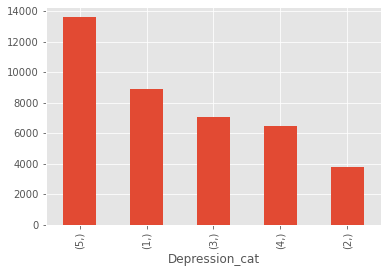

In [9]:
plt.style.use('ggplot')
depress[['Depression_cat']].value_counts().plot(kind='bar')

In [10]:
depress[['Depression_cat']].value_counts()/depress.shape[0]*100

Depression_cat
5                 34.134507
1                 22.265242
3                 17.797612
4                 16.284098
2                  9.518542
dtype: float64

<AxesSubplot:xlabel='Anxiety_cat'>

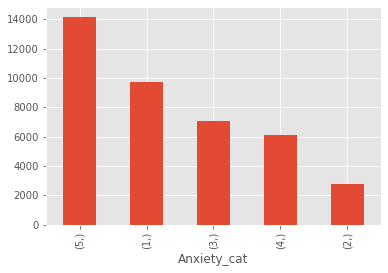

In [11]:
depress[['Anxiety_cat']].value_counts().plot(kind='bar')

<AxesSubplot:xlabel='Stress_cat'>

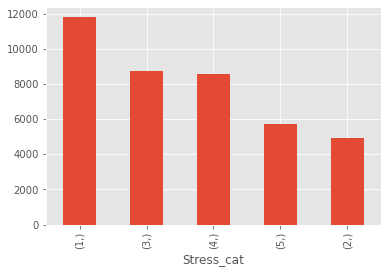

In [12]:
depress[['Stress_cat']].value_counts().plot(kind='bar')

## Demographics of survey respondents

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'education'}>],
       [<AxesSubplot:title={'center':'orientation'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'urban'}>],
       [<AxesSubplot:title={'center':'married'}>,
        <AxesSubplot:title={'center':'familysize'}>,
        <AxesSubplot:title={'center':'religion'}>],
       [<AxesSubplot:title={'center':'screensize'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

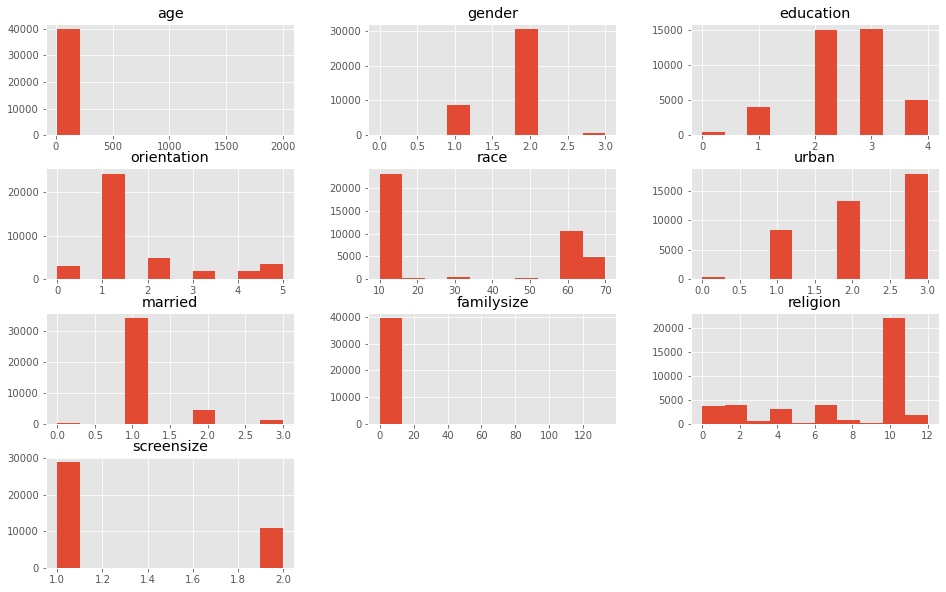

In [13]:
depress[['age', 'gender', 'education','orientation','race','urban','married','familysize','religion',\
         'screensize']].hist(figsize=(16,10))

<AxesSubplot:>

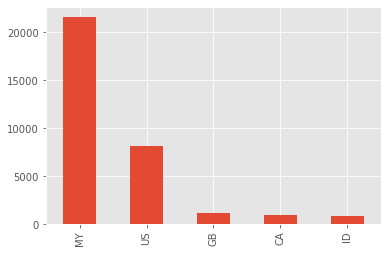

In [14]:
depress['country'].value_counts(ascending=False).head(5).plot(kind='bar')

### Personality trait score by gender

[Text(0, 0, 'Unknown'),
 Text(1, 0, 'Male'),
 Text(2, 0, 'Female'),
 Text(3, 0, 'Other')]

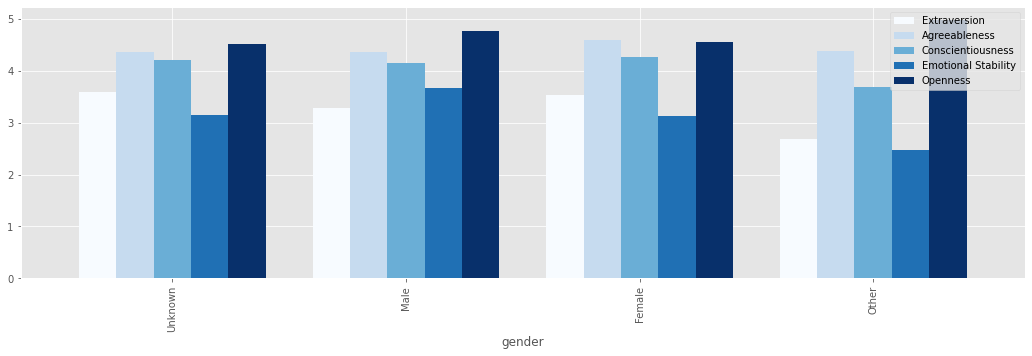

In [15]:
pers_gender = depress[["Extraversion","Agreeableness","Conscientiousness","Emotional Stability","Openness\
","gender"]].groupby(by='gender').mean().plot(kind="bar", figsize=(18,5), colormap="Blues", width=0.8)
pers_gender.set_xticklabels( ('Unknown','Male', 'Female','Other') )

### Personality trait score by age

<AxesSubplot:xlabel='Age Group'>

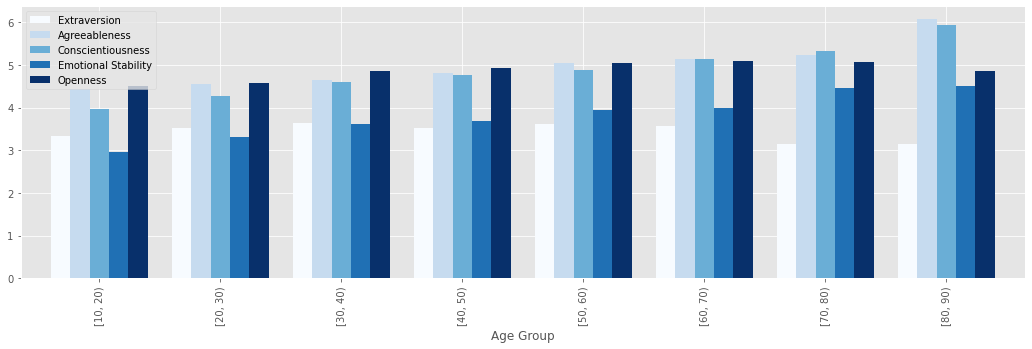

In [16]:
pers_age2 = depress[["Extraversion","Agreeableness","Conscientiousness","Emotional Stability","Openness\
","age"]]
bins = list(range(10, 100, 10))
pers_age2['Age Group'] = pd.cut(pers_age2['age'], bins, right=False)
pers_age2[["Extraversion","Agreeableness","Conscientiousness","Emotional Stability","Openness\
","Age Group"]].groupby(by='Age Group').mean().plot(kind="bar", figsize=(18,5), colormap="Blues", width=0.8)

### Removing Outliers

Removing outliers in age and family size and replacing age with inferred values where possible

In [17]:
def fix_outliers_iqr(ser, strategy='median', iqr_multiplier=3, constant=-1):
    q1=ser.quantile(0.25); q3=ser.quantile(0.75)
    iqr=(q3-q1)*iqr_multiplier
    upper_bound=iqr+q3; lower_bound=max(0,q1-iqr)
    mask = (ser>upper_bound) | (ser<lower_bound)
    
    if strategy=='median':
        ser = np.where(mask,ser.median(),ser)
    elif strategy=='mean':
        ser = np.where(mask,ser.mean(),ser)
    elif strategy=='constant':
        ser = np.where(mask,constant,ser)
    else:
        print ("Keyed-in strategy is outside of scope of requirements. Returning the series as it is...")
    return ser

In [18]:
depress_fil = depress[depress.columns.drop(list(depress.filter(regex='Q\d{1,2}A|Q\d{1,2}E|Q\d{1,2}I|TIPI\d+|VCL\d+')))]
depress_fil.drop(columns=['source','introelapse','testelapse','surveyelapse','uniquenetworklocation'], inplace=True)
depress_fil["age"].replace({1998: 20, 1996: 22,1993: 25,1991: 27}, inplace=True)

array([[<AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'urban'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'engnat'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'screensize'}>,
        <AxesSubplot:title={'center':'hand'}>,
        <AxesSubplot:title={'center':'religion'}>,
        <AxesSubplot:title={'center':'orientation'}>,
        <AxesSubplot:title={'center':'race'}>],
       [<AxesSubplot:title={'center':'voted'}>,
        <AxesSubplot:title={'center':'married'}>,
        <AxesSubplot:title={'center':'familysize'}>,
        <AxesSubplot:title={'center':'Depression'}>,
        <AxesSubplot:title={'center':'Anxiety'}>],
       [<AxesSubplot:title={'center':'Stress'}>,
        <AxesSubplot:title={'center':'Depression_cat'}>,
        <AxesSubplot:title={'center':'Anxiety_cat'}>,
        <AxesSubplot:title={'center':'Stress_cat'}>,
        <AxesSubplot:title={'cente

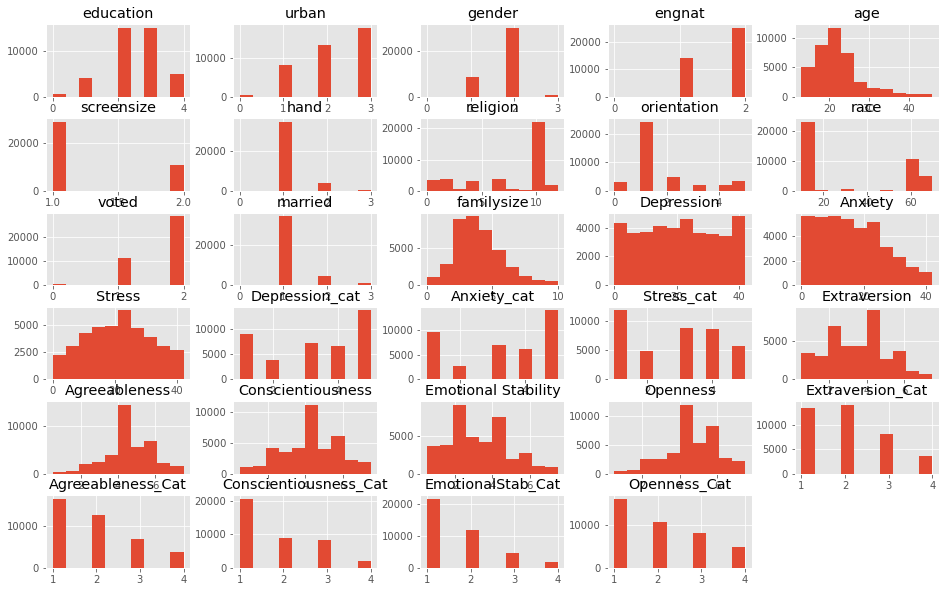

In [19]:
depress_fil['familysize']=fix_outliers_iqr(depress_fil['familysize'], strategy='median')
depress_fil['age']=fix_outliers_iqr(depress_fil['age'], strategy='median')
depress_fil.hist(figsize=(16,10), bins=10)

### One-hot encoding for categorical variables

In [20]:
top_10_country = depress_fil.country.value_counts(ascending=False).head(11) ; top_10_country

MY      21605
US       8207
GB       1180
CA        978
ID        884
PH        749
AU        608
NONE      539
IN        446
DE        314
SG        292
Name: country, dtype: int64

In [21]:
depress_encode = depress_fil.copy()
depress_encode.country[depress_encode.country.replace(Counter(depress_encode.country)) < 292] = 'Other'
depress_encode["country"].replace({'NONE': 'Other'}, inplace=True)

In [22]:
top_religion = depress_encode.religion.value_counts(ascending=False).head(6) ; top_religion
depress_encode.religion[depress_encode.religion.replace(Counter(depress_encode.religion)) < 1804] = 'Other'
depress_encode.religion.value_counts()

10       22073
2         3845
Other     3457
1         3245
4         3097
7         2254
12        1804
Name: religion, dtype: int64

In [23]:
top_race = depress_encode.race.value_counts(ascending=False).head(3) ; top_race
depress_encode.race[depress_encode.race.replace(Counter(depress_encode.race)) < 4832] = 'Other'
depress_encode.race.value_counts()

10       23106
60       10659
70        4832
Other     1178
Name: race, dtype: int64

In [24]:
categorical_cols = ['country','education','urban','gender','screensize','hand','religion','orientation'\
                    ,'race','voted','married']
depress_encode = pd.get_dummies(depress_encode, columns = categorical_cols, drop_first = True)

In [25]:
depress_encode = depress_encode.drop(columns = ['major','engnat','Depression','Anxiety_cat','Stress_cat','Extraversion_Cat','Agreeableness_Cat'\
                                                , 'Openness_Cat','Conscientiousness_Cat','EmotionalStab_Cat'])

## Correlation of variables

In [26]:
depress_corr = depress_fil.drop(columns = ['major','engnat','Depression_cat','Anxiety_cat','Stress_cat','Extraversion_Cat','Agreeableness_Cat'\
                                                , 'Openness_Cat','Conscientiousness_Cat','EmotionalStab_Cat'])

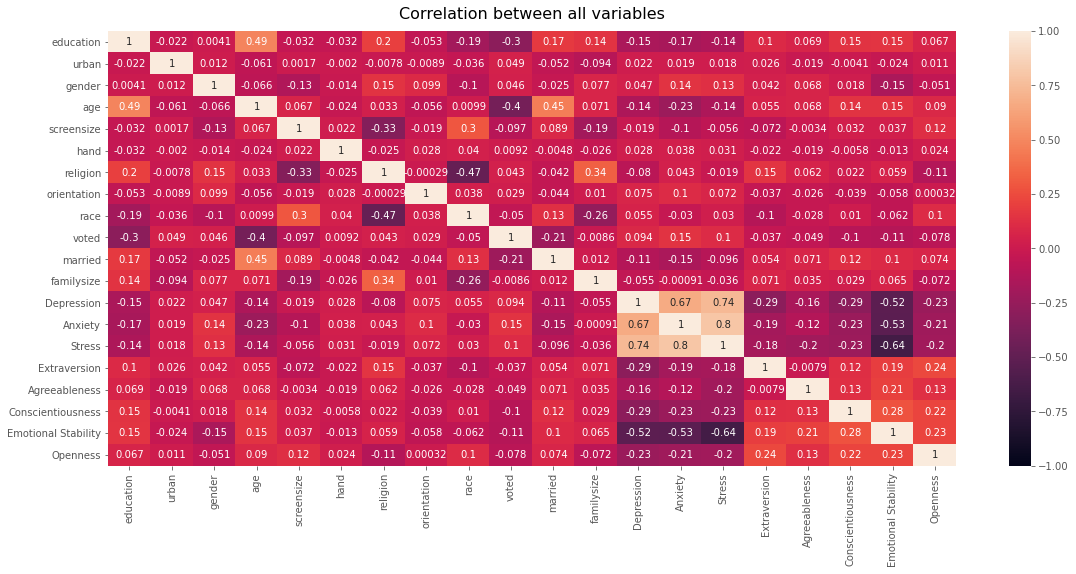

In [27]:
plt.figure(figsize=(19, 8))
heatmap = sns.heatmap(depress_corr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between all variables', fontdict={'fontsize':16}, pad=12);

### Zooming into personality traits and DAS 

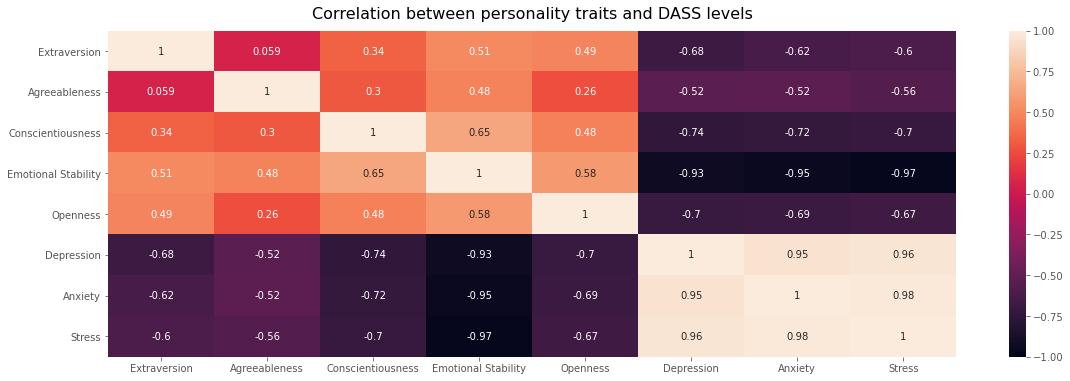

In [28]:
df_personality = depress[personality]
df_dass = depress[['Depression','Anxiety','Stress']]
dass_pers = pd.concat([df_personality,df_dass],axis=1).corr()
plt.figure(figsize=(19, 6))
heatmap = sns.heatmap(dass_pers.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between personality traits and DASS levels', fontdict={'fontsize':16}, pad=12);

### Assessing highly correlated independent variables via variance inflation factor

Anxiety and Stress were found to be highly correlated, drop stress for model building

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_variables = depress[['Anxiety','Stress','Emotional Stability']]
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,Anxiety,9.706904
1,Stress,10.871426
2,Emotional Stability,1.902881


## Building our model

### Splitting Train and Test Set

In [30]:
feature_cols = depress_encode.columns.drop(['Depression_cat','Stress']).tolist()

In [31]:
X = depress_encode[feature_cols]
y = depress_encode.Depression_cat

### Implementing SMOTE to address class imbalance

In [32]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (39775, 51)
Shape of X after SMOTE: (67885, 51)

Balance of classes (%):


1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
Name: Depression_cat, dtype: float64

#### Train test split with SMOTE 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42)

#### Train test split without SMOTE

In [34]:
X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.25, random_state=42)

### Scaling

#### The dataset will be tested on both decision tree models and distance-based models

In [35]:
#Scaling was not used on the data, as it didn't improve the accuracy of SVC and reduced the accuracy of KNN
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline model - Zero Rate and Random Weight Guessing

In [36]:
from sklearn.dummy import DummyClassifier

In [37]:
dummy_clf = DummyClassifier(strategy="most_frequent") #Zero Rate
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.34134506599622877

In [38]:
dummy_clf = DummyClassifier(strategy="stratified") #Random Weight Guessing
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.23522313010685103

### Looping through various machine learning models without hyperparameter tuning

In [39]:
import time
def run_exp(X_train, y_train, X_test, y_test):
    
    models = [
        ('LR', LogisticRegression(solver = 'lbfgs', max_iter = 1000)), 
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVC', SVC()), 
        ('XGB', XGBClassifier())
        ]
    
    results = []
    names = []
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro'] #using macro metrics for multiclass problem
    target_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']
    dfs=[]
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        start = time.time()
        md = model.fit(X_train, y_train)
        y_pred = md.predict(X_test)
        stop = time.time()
        print(f"Training and prediction time: {stop - start}s")
        
        results.append(cv_results)
        names.append(name)
        
        df_results = pd.DataFrame(cv_results)
        df_results['model'] = name
        dfs.append(df_results)
        print(name)
        print(classification_report(y_test, y_pred, target_names = target_names))

        final = pd.concat(dfs, ignore_index=True)

    return final

#### Run models without SMOTE 

In [40]:
run_exp(X_trains, y_trains, X_tests, y_tests)

Training and prediction time: 8.37063217163086s
LR
                  precision    recall  f1-score   support

          Normal       0.54      0.81      0.65      2202
            Mild       0.00      0.00      0.00       914
        Moderate       0.32      0.26      0.29      1790
          Severe       0.18      0.01      0.01      1626
Extremely Severe       0.57      0.85      0.68      3412

        accuracy                           0.52      9944
       macro avg       0.32      0.39      0.33      9944
    weighted avg       0.40      0.52      0.43      9944

Training and prediction time: 3.1775002479553223s
RF
                  precision    recall  f1-score   support

          Normal       0.56      0.76      0.65      2202
            Mild       0.24      0.03      0.06       914
        Moderate       0.31      0.23      0.26      1790
          Severe       0.27      0.09      0.13      1626
Extremely Severe       0.58      0.83      0.68      3412

        accuracy     

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,model
0,6.754850,0.006436,0.510139,0.365624,0.383069,0.324436,LR
1,6.873357,0.006618,0.506202,0.300255,0.383063,0.318545,LR
2,6.686195,0.006224,0.520952,0.338490,0.384902,0.323172,LR
3,6.762793,0.006407,0.525645,0.328005,0.385427,0.326653,LR
4,6.755483,0.006427,0.512571,0.316878,0.378148,0.320377,LR
5,2.441688,0.132277,0.502765,0.369215,0.384022,0.348691,RF
6,2.383404,0.130921,0.504693,0.377149,0.389381,0.348595,RF
7,2.338603,0.126867,0.521623,0.403600,0.397875,0.364896,RF
8,2.340173,0.126012,0.522461,0.391062,0.391240,0.357577,RF
9,2.387336,0.127792,0.512236,0.372906,0.385295,0.348172,RF


#### Modify function to drop SVC model - run time is too long with similar results to other models

In [41]:
def run_exp2(X_train, y_train, X_test, y_test):
    
    models = [
        ('LR', LogisticRegression(solver = 'lbfgs', max_iter = 1000)), 
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()), 
        ('XGB', XGBClassifier())
        ]
    
    results = []
    names = []
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro'] #using macro metrics for multiclass problem
    target_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']
    dfs=[]
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        start = time.time()
        md = model.fit(X_train, y_train)
        y_pred = md.predict(X_test)
        stop = time.time()
        print(f"Training and prediction time: {stop - start}s")
        
        results.append(cv_results)
        names.append(name)
        
        df_results = pd.DataFrame(cv_results)
        df_results['model'] = name
        dfs.append(df_results)
        print(name)
        print(classification_report(y_test, y_pred, target_names = target_names))

        final = pd.concat(dfs, ignore_index=True)

    return final

#### Run models with SMOTE 

In [42]:
run_exp2(X_train, y_train, X_test, y_test)

Training and prediction time: 16.422669887542725s
LR
                  precision    recall  f1-score   support

          Normal       0.54      0.69      0.61      3374
            Mild       0.43      0.43      0.43      3346
        Moderate       0.32      0.21      0.25      3427
          Severe       0.45      0.33      0.38      3357
Extremely Severe       0.58      0.78      0.66      3468

        accuracy                           0.49     16972
       macro avg       0.47      0.49      0.47     16972
    weighted avg       0.47      0.49      0.47     16972

Training and prediction time: 7.060892105102539s
RF
                  precision    recall  f1-score   support

          Normal       0.69      0.77      0.72      3374
            Mild       0.74      0.73      0.73      3346
        Moderate       0.61      0.53      0.57      3427
          Severe       0.64      0.59      0.62      3357
Extremely Severe       0.66      0.73      0.69      3468

        accuracy    

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,model
0,12.727587,0.012437,0.485515,0.460870,0.486672,0.465404,LR
1,12.778616,0.012272,0.485417,0.464079,0.487400,0.464622,LR
2,12.942034,0.011501,0.479721,0.454179,0.479392,0.457346,LR
3,12.990496,0.012698,0.486840,0.462998,0.487397,0.466108,LR
4,13.560125,0.012857,0.486250,0.461941,0.484693,0.463967,LR
5,5.528271,0.233766,0.644113,0.640166,0.643823,0.639444,RF
6,5.240795,0.228118,0.649121,0.647311,0.649909,0.645527,RF
7,5.266064,0.225882,0.649809,0.647302,0.649778,0.645981,RF
8,5.138790,0.225589,0.647417,0.644277,0.647686,0.643679,RF
9,5.200614,0.226853,0.642408,0.639860,0.641690,0.638054,RF


#### Run models with SMOTE and scaling

In [43]:
run_exp2(X_train_scaled, y_train, X_test_scaled, y_test)

Training and prediction time: 4.421653985977173s
LR
                  precision    recall  f1-score   support

          Normal       0.54      0.69      0.61      3374
            Mild       0.43      0.43      0.43      3346
        Moderate       0.32      0.20      0.25      3427
          Severe       0.45      0.33      0.38      3357
Extremely Severe       0.57      0.78      0.66      3468

        accuracy                           0.49     16972
       macro avg       0.46      0.49      0.46     16972
    weighted avg       0.46      0.49      0.47     16972

Training and prediction time: 6.916860818862915s
RF
                  precision    recall  f1-score   support

          Normal       0.68      0.76      0.72      3374
            Mild       0.74      0.72      0.73      3346
        Moderate       0.62      0.52      0.57      3427
          Severe       0.65      0.59      0.62      3357
Extremely Severe       0.65      0.74      0.69      3468

        accuracy     

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,model
0,3.592787,0.010768,0.483747,0.458937,0.484910,0.463250,LR
1,3.527759,0.010582,0.484337,0.462978,0.486342,0.463268,LR
2,3.398790,0.010567,0.478543,0.452184,0.478238,0.455255,LR
3,3.531820,0.010856,0.488509,0.464442,0.489048,0.466838,LR
4,3.521626,0.010496,0.486054,0.461996,0.484501,0.463008,LR
5,5.417710,0.224711,0.645193,0.641681,0.644776,0.640814,RF
6,5.148625,0.222079,0.647943,0.646267,0.648707,0.644516,RF
7,4.989090,0.226136,0.646371,0.643291,0.646343,0.642010,RF
8,5.019437,0.221369,0.651738,0.648957,0.651983,0.648159,RF
9,5.064774,0.219899,0.644863,0.642188,0.644116,0.640314,RF


### Confusion matrix

In [44]:
import matplotlib
def run_confusion_matrix(y_test):
    models = [
    ('LR', LogisticRegression(solver = 'lbfgs', max_iter = 1000)), 
    ('RF', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('XGB', XGBClassifier())
    ]
    for name,model in models:
        md = model.fit(X_train, y_train)
        y_pred = md.predict(X_test)
        print(name)
        sns.set(font_scale=1.2)#for label size
        ax = sns.heatmap(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred), 
                         annot=True, cmap='Reds', annot_kws={"size": 16, "ha": 'center',"va": 'center'},fmt='d', linewidths=1, linecolor='black')
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

        for t in ax.texts:
            trans = t.get_transform()
            offs = matplotlib.transforms.ScaledTranslation(+0.24, 0.24,
                            matplotlib.transforms.IdentityTransform())
            t.set_transform( offs + trans )  

        plt.tight_layout(); plt.show()
    return None

LR


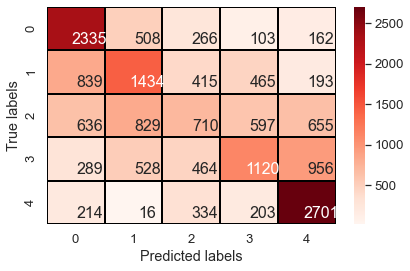

RF


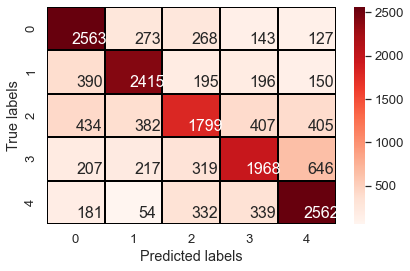

KNN


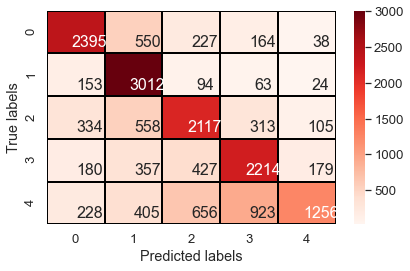

[16:48:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB


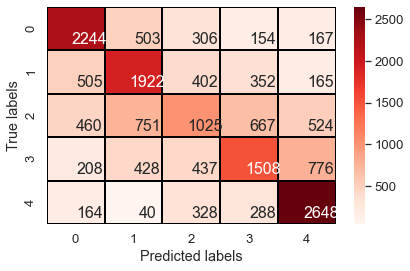

None


In [45]:
print (run_confusion_matrix(y_test))

### Feature Importance/ Selection

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
def get_feature_importance(model, features):
    return pd.DataFrame({'features':features, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=True)

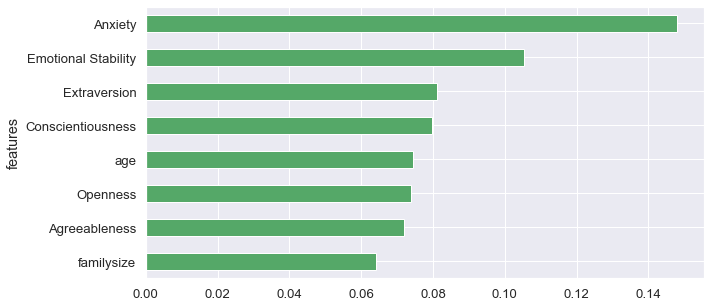

In [48]:
df_fi = get_feature_importance(rf, feature_cols)
df_fi[df_fi.imp>0.05].plot('features', 'imp', 'barh', figsize=(10,5), color='g', legend=False);

### Rerunning our model with selected features only

In [49]:
feature_recol = ['Anxiety','Emotional Stability','Extraversion','Conscientiousness','age','Agreeableness',\
                 'Openness','familysize']
X_Re = depress_encode[feature_recol]
X_Resm, y_Resm = sm.fit_resample(X_Re, y)
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')
print('\nBalance of classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (39775, 51)
Shape of X after SMOTE: (67885, 51)

Balance of classes (%):


1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
Name: Depression_cat, dtype: float64

In [50]:
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_Resm, y_Resm, test_size=0.25, random_state=42)

In [51]:
run_exp(X_trainr, y_trainr, X_testr, y_testr)

Training and prediction time: 5.795010089874268s
LR
                  precision    recall  f1-score   support

          Normal       0.52      0.69      0.59      3374
            Mild       0.32      0.29      0.30      3346
        Moderate       0.30      0.20      0.24      3427
          Severe       0.33      0.29      0.31      3357
Extremely Severe       0.53      0.65      0.59      3468

        accuracy                           0.42     16972
       macro avg       0.40      0.42      0.41     16972
    weighted avg       0.40      0.42      0.41     16972

Training and prediction time: 6.196369886398315s
RF
                  precision    recall  f1-score   support

          Normal       0.68      0.76      0.72      3374
            Mild       0.73      0.72      0.72      3346
        Moderate       0.62      0.55      0.58      3427
          Severe       0.64      0.60      0.62      3357
Extremely Severe       0.66      0.71      0.68      3468

        accuracy     

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,model
0,2.822046,0.011038,0.416282,0.394301,0.417392,0.399744,LR
1,5.149119,0.011406,0.420308,0.397986,0.421685,0.404258,LR
2,4.807979,0.010728,0.419719,0.397231,0.419241,0.402525,LR
3,5.153189,0.011032,0.423001,0.400344,0.423806,0.406054,LR
4,4.177873,0.010661,0.431251,0.408224,0.430015,0.413844,LR
5,5.014058,0.212885,0.637042,0.633959,0.636622,0.634471,RF
6,4.886404,0.216429,0.639595,0.636305,0.640102,0.636421,RF
7,4.626526,0.210531,0.646175,0.643776,0.646085,0.643740,RF
8,4.681672,0.211159,0.641721,0.639021,0.642056,0.639186,RF
9,4.664993,0.218017,0.646140,0.643822,0.645612,0.643935,RF


### Creating a pipeline for multiple models on Randomized Search and Grid Search

In [52]:
"""
rf = RandomForestClassifier(random_state=42)
#svc = SVC()
lg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
xgb = XGBClassifier()
"""

'\nrf = RandomForestClassifier(random_state=42)\n#svc = SVC()\nlg = LogisticRegression(random_state=42)\nknn = KNeighborsClassifier()\nxgb = XGBClassifier()\n'

In [53]:
"""
rf_param = {}
rf_param['classifier__n_estimators'] = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 2)]
rf_param['classifier__max_depth'] = [int(x) for x in np.linspace(10, 110, num = 2)]
rf_param['classifier__max_features'] = [0.2,'sqrt']
rf_param['classifier__min_samples_leaf'] = [1, 2]
rf_param['classifier__min_samples_split'] = [2, 10]
rf_param['classifier__bootstrap'] = [True, False]
rf_param['classifier__criterion'] = ['gini','entropy']
rf_param['classifier'] = [rf]


svc_param = {}
svc_param['classifier__kernels'] = ['linear', 'rbf', 'poly']
svc_param['classifier__gammas'] = [0.1, 1, 10, 100]
svc_param['classifier__c'] = [0.1, 1, 10, 100, 1000]
svc_param['classifier__degrees'] = [0, 1, 2, 3, 4, 5, 6]
svc_param['classifier'] = [svc]


lg_param = {}
lg_param['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
lg_param['classifier__penalty'] = ['l1', 'l2','elasticnet']
lg_param['classifier'] = [lg]


knn_param = {}
knn_param['classifier__n_neighbors'] = [5,10,25,50]
knn_param['classifier'] = [knn]

xgb_param = {}
xgb_param['classifier__max_depth'] = [int(x) for x in np.linspace(10, 110, num = 5)]
xgb_param['classifier__n_estimators'] = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
xgb_param['classifier__colsample_bytree']: [0.3, 0.7]
xgb_param['classifier'] = [xgb]
"""

"\nrf_param = {}\nrf_param['classifier__n_estimators'] = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 2)]\nrf_param['classifier__max_depth'] = [int(x) for x in np.linspace(10, 110, num = 2)]\nrf_param['classifier__max_features'] = [0.2,'sqrt']\nrf_param['classifier__min_samples_leaf'] = [1, 2]\nrf_param['classifier__min_samples_split'] = [2, 10]\nrf_param['classifier__bootstrap'] = [True, False]\nrf_param['classifier__criterion'] = ['gini','entropy']\nrf_param['classifier'] = [rf]\n\n\nsvc_param = {}\nsvc_param['classifier__kernels'] = ['linear', 'rbf', 'poly']\nsvc_param['classifier__gammas'] = [0.1, 1, 10, 100]\nsvc_param['classifier__c'] = [0.1, 1, 10, 100, 1000]\nsvc_param['classifier__degrees'] = [0, 1, 2, 3, 4, 5, 6]\nsvc_param['classifier'] = [svc]\n\n\nlg_param = {}\nlg_param['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]\nlg_param['classifier__penalty'] = ['l1', 'l2','elasticnet']\nlg_param['classifier'] = [lg]\n\n\nknn_param = {}\nknn_param['classifi

In [54]:
#pipeline = Pipeline([('classifier', rf)])
#params = [rf_param]

In [55]:
"""
%%time
from sklearn.metrics import make_scorer
f1_macro = make_scorer(f1_score, average='macro')
rs = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring=f1_macro).fit(X_train, y_train)
"""

"\n%%time\nfrom sklearn.metrics import make_scorer\nf1_macro = make_scorer(f1_score, average='macro')\nrs = RandomizedSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring=f1_macro).fit(X_train, y_train)\n"

In [56]:
#rs.best_params_

In [57]:
#rs.best_score_

In [58]:
"""
y_pred = rs.predict(X_test)
target_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']
print(classification_report(y_test, y_pred, target_names = target_names))
"""

"\ny_pred = rs.predict(X_test)\ntarget_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']\nprint(classification_report(y_test, y_pred, target_names = target_names))\n"

Given that we know random forest classifier is the best model from randomized search, we reduce the scale of our search on Grid Search using randomized search's best param as a guide

In [59]:
rf_param2 = {}
rf_param2['n_estimators'] = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 5)]
rf_param2['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 5)]
rf_param2['max_features'] = [0.2,0.4]
rf_param2['min_samples_leaf'] = [1, 2]
rf_param2['min_samples_split'] = [2,5,10]
rf_param2['bootstrap'] = [True, False]
rf_param2['criterion'] = ['gini','entropy']

In [60]:
rf_param2

{'n_estimators': [100, 575, 1050, 1525, 2000],
 'max_depth': [10, 35, 60, 85, 110],
 'max_features': [0.2, 0.4],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']}

In [61]:
%%time
gs = RandomizedSearchCV(RandomForestClassifier(random_state = 42), rf_param2, cv=3).fit(X_train, y_train)

CPU times: user 43min 27s, sys: 15.9 s, total: 43min 43s
Wall time: 43min 49s


In [62]:
gs.best_params_

{'n_estimators': 1050,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.2,
 'max_depth': 110,
 'criterion': 'gini',
 'bootstrap': True}

In [63]:
gs.best_score_

0.6483020053817296

In [64]:
y_pred = gs.predict(X_test)
target_names = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']
print(classification_report(y_test, y_pred, target_names = target_names))

                  precision    recall  f1-score   support

          Normal       0.70      0.77      0.73      3374
            Mild       0.77      0.75      0.76      3346
        Moderate       0.64      0.57      0.60      3427
          Severe       0.67      0.61      0.64      3357
Extremely Severe       0.66      0.75      0.70      3468

        accuracy                           0.69     16972
       macro avg       0.69      0.69      0.69     16972
    weighted avg       0.69      0.69      0.69     16972

